<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit

## Подготовка

In [2]:
#Признак даты делаем индексом, чтобы преобразовать датафрейм во временной ряд
try:

    data = pd.read_csv('/Users/paulinesmirnova/Desktop/Практикум/taxi.csv', index_col=[0], parse_dates=[0])
except:


    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


## Анализ

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
#Resample by hour
data = data.resample('1H').sum()

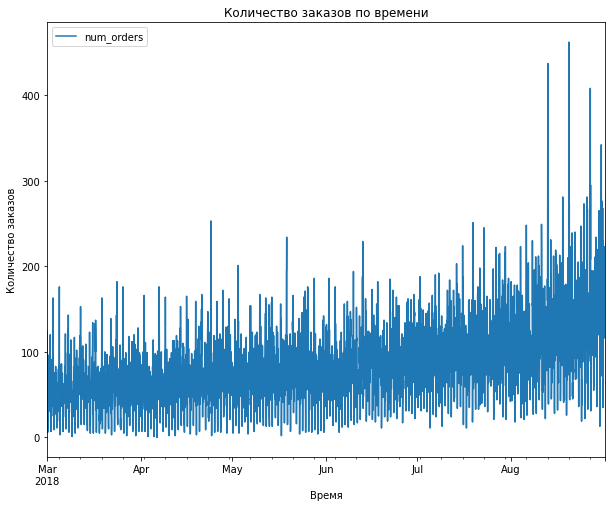

In [6]:
data.plot(figsize=(10,8))
plt.title('Количество заказов по времени')
plt.xlabel('Время')
plt.ylabel('Количество заказов');

Количество заказов растет от марта к августу, в некоторые часы есть значения похожие на выбрросы, но так как данные реальные, колебания допустимы. 

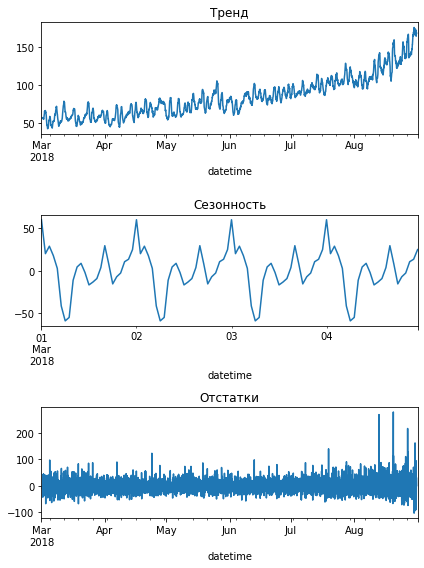

In [7]:
#Попробуем разложить данные на сезонность, тренды и остаток, чтобы проследить закономерности 
decomposed = seasonal_decompose(data)
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-04'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Отстатки')
plt.tight_layout()

Виден четкий тренд на увеливение количества заказов такси от начала весны и к концу лета. 
Сезонность сморим по промежутку с 1 по 5 января 2018 года для большей наглядности. Видна суточная сезонность, когда в зависимости от часа дня количество заказов то уменьшается то увеличивается. Пики активности видны ближе к вечеру, а спады ночью, в первые часы наступивших суток. Вероятно, это связано с тем, что в это время прилетает наименьшее количество рейсов. 

## Обучение
Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.

In [8]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek

    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)
    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_new

In [9]:
#Создаем признаки в новый датасет
data_new = make_features(data, 30, 50)
data_new

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,198.0,142.0,72.0,177.0,342.0,254.0,156.0,91.0,154.0,169.64
2018-08-31 20:00:00,154,31,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,158.0,198.0,142.0,72.0,177.0,342.0,254.0,156.0,91.0,169.18
2018-08-31 21:00:00,159,31,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,246.0,158.0,198.0,142.0,72.0,177.0,342.0,254.0,156.0,169.86


In [10]:
#Делим на тренировочную и тестовую выборки, без перемешивания, чтобы модель не обучалась на данных из будущего
train, test = train_test_split(data_new, shuffle=False, test_size=0.1)
train = train.dropna()

print(train.shape)
print(test.shape)

(3924, 34)
(442, 34)


In [11]:
train_features = train.drop(['num_orders'], axis=1)
train_target = train['num_orders']
test_features = test.drop(['num_orders'], axis=1)
test_target = test['num_orders']

model = LinearRegression().fit(train_features, train_target)

train_pred = model.predict(train_features)
test_pred = model.predict(test_features)

rmse = mean_squared_error(train_target, train_pred)**.5
rmse_test = mean_squared_error(test_target, test_pred)**.5

print('RMSE модели: {:.4f}'.format(rmse))
print('RMSE модели на тестовых данных: {:.4f}'.format(rmse_test))
print("MAE обучающей выборки:", mean_absolute_error(train_target, train_pred))

RMSE модели: 25.3457
RMSE модели на тестовых данных: 44.5969
MAE обучающей выборки: 19.29904070511366


In [12]:
pred_previous = test['num_orders'].shift(fill_value=train['num_orders'].iloc[-1])
rmse_base =  mean_squared_error(test['num_orders'], pred_previous) ** 0.5
print("RMSE модели:", round(rmse_base, 3))

RMSE модели: 58.856


In [13]:
print("Среднее число заказов такси в час:", test['num_orders'].mean())
print("MAE:", mean_absolute_error(test['num_orders'], pred_previous))

Среднее число заказов такси в час: 139.55656108597285
MAE: 44.97285067873303


Метрика RMSE небольшая, что говорит о правильно подобранной модели. 
Попробуем еще одну модель для прогнозирования. 

In [17]:
regr = lgb.LGBMRegressor()

param_search = {'max_depth' : [3, 5]}

tscv = TimeSeriesSplit(n_splits=len(data_new['dayofweek'].unique()) - 1)

gsearch = GridSearchCV(estimator=regr, cv=tscv,
                        param_grid=param_search)
gsearch.fit(train_features, train_target)

regr_best = gsearch.best_estimator_

## Тестирование

In [18]:
train_result = mean_squared_error(train_target, regr_best.predict(train_features), squared=False)
test_result = mean_squared_error(test_target, regr_best.predict(test_features), squared=False)
print('Train RMSE:', round(train_result,2))
print('Test RMSE:', round(test_result,2))

Train RMSE: 16.13
Test RMSE: 42.08


Метрика стала чуть больше, но все еще не больше 48. 

In [19]:
true_pred = pd.DataFrame({ 
    'y_true' : test_target,
    'y_pred' : regr_best.predict(test_features)
    })

<AxesSubplot:xlabel='datetime'>

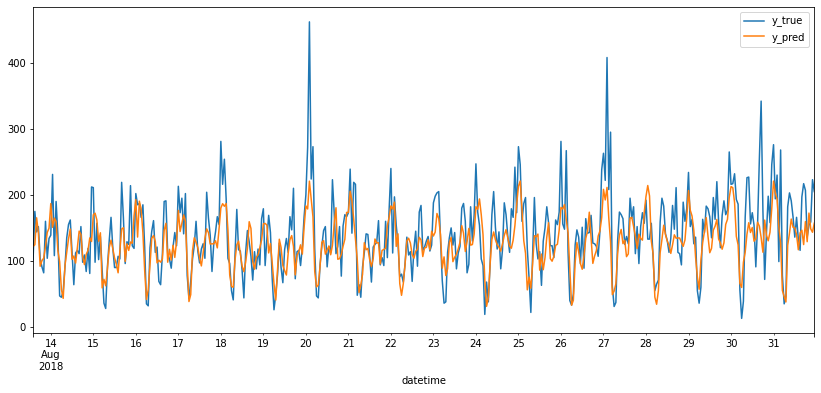

In [20]:
true_pred.plot(figsize=(14,6))

По графику видно, что предсказания близки к результатам на тренировочной выборке. 

## Вывод

В начале работы данные были загружены и ресемплированы по одному часу для удобства дальнейшей работы. Чтобы проследить закономерности в данных был составлен общий график разброса значений. Далее данные были разложены на сезонность, тренды и остатки. Сезонность не имеет смысла, так как данные за слишком короткий период. Виден четкий тренд на увеливение количества заказов такси от начала весны и к концу лета. 
Дальше данные были разделены на две выборки, тестовая выборка была размером 10% от всех данных. Модель линейной регрессии была обучена на тренировочных данных. Результат метрики RMSE на тренировочных данных был 7.43. Далее была обробована модель LGBMRegressor. Результат метрики RMSE на тестовых данных 7.13. Немного лучше результаты у линейной регрессии. 